# Multi-Modal Gaussian Process Variational Autoencoder (MM-GPVAE)

------------------------------------------------------

### To run this notebook please first run data_generator.py and enter the path to your data below

In [1]:
DATA_PATH = './mmgpvae_data_seed32.npy'

MMGPVAE = f'fourier_mmgpvae700closedform_noprune'

## Package Imports

In [2]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import Dataset
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
import scipy as sp
import pylab as pl
import numpy as np
from sklearn.model_selection import train_test_split
import GP_fourier as gpf
from train import *
from misc import *
from neural_nets import *

torch.manual_seed(my_seed)
np.random.seed(my_seed)

## DataLoader 

In [3]:
torch.manual_seed(my_seed)

full_dataset = TimePointCustomDataset(DATA_PATH)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size],
generator=torch.Generator().manual_seed(DATA_SPLIT_SEED))
loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH)
loader_test= torch.utils.data.DataLoader(test_dataset, batch_size=BATCH)

torch.Size([300, 60, 1296])
torch.Size([300, 60])


In [4]:
## Unbatched data
torch.manual_seed(my_seed)
full_data = torch.utils.data.DataLoader(full_dataset, batch_size=BATCH)
train_data_unbatched = torch.utils.data.DataLoader(train_dataset, 
batch_size=train_dataset.__len__())
test_data_unbatched = torch.utils.data.DataLoader(test_dataset, 
batch_size=test_dataset.__len__())

In [5]:
## Printing shapes & getting the meanrates to initialize our neural decoder
for data, labels, spikes, neural_rates, gp1, gp2, zoom in train_data_unbatched:
    print(f'Shape of images {data.shape}')
    print(f'Shape of angles {labels.shape}')
    print(f'Shape of spikes {spikes.shape}')
    print(f'Shape of rates {neural_rates.shape}')
    meanrates = np.mean(neural_rates.detach().numpy(), axis = (0,1))
    break
    

Shape of images torch.Size([240, 60, 1296])
Shape of angles torch.Size([240, 60])
Shape of spikes torch.Size([240, 60, 100])
Shape of rates torch.Size([240, 60, 100])


In [6]:
FOURIER = True

In [7]:
net= Behavior_Encoder_Decoder(zimg_Dim=N_lats_img, 
                              Fourier = FOURIER,  minlens =10)
n_encode = Spike_Encode(zDim=N_lats_spikes, Fourier = FOURIER,
                        minlens =10)
n_decode = Spike_Decode(meanrates=meanrates,
                        zDim=N_lats_spikes, 
                        Fourier = FOURIER, minlens =10)

## Training 

Epoch 0 | Loss: 46184428.58
Epoch 50 | Loss: 30575205.35
Epoch 100 | Loss: 28374107.50
Epoch 150 | Loss: 27945862.97
Epoch 200 | Loss: 27434122.20
Epoch 250 | Loss: 26929808.07
Epoch 300 | Loss: 26466349.46
Epoch 350 | Loss: 25884931.38
Epoch 400 | Loss: 25525260.24
Epoch 450 | Loss: 25248958.73
Epoch 500 | Loss: 24717342.58
Epoch 550 | Loss: 24359911.97
Epoch 600 | Loss: 24179639.50
Epoch 650 | Loss: 23922799.67


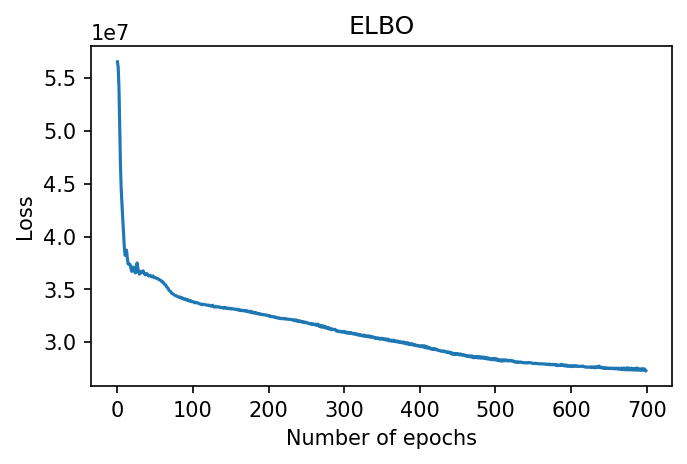

In [8]:
trained = train_model_mmgpvae_closed(net, n_encode, n_decode, loader_train,
                EPOCH = TOTAL_EPOCH, lr1=image_lr, lr2=0.000772, lr3=0.0088, 
                Fourier = FOURIER, visualize_ELBO = True, zero_neuro = 1,
                zero_image = 1, gpvae_mode = False,
                gpfa_mode = False, mmgpvae=True)

## Visualizing the latent traces

/Users/rabiagondur/Desktop/ICLR/misc.py:510: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  W = np.linalg.lstsq(recon_z_const.T, z.T)[0]
/Users/rabiagondur/Desktop/ICLR/misc.py:533: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  W1 = np.linalg.lstsq(recon_z_const_zoom.T, z_zoom.T)[0]
/Users/rabiagondur/Desktop/ICLR/misc.py:556: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warni

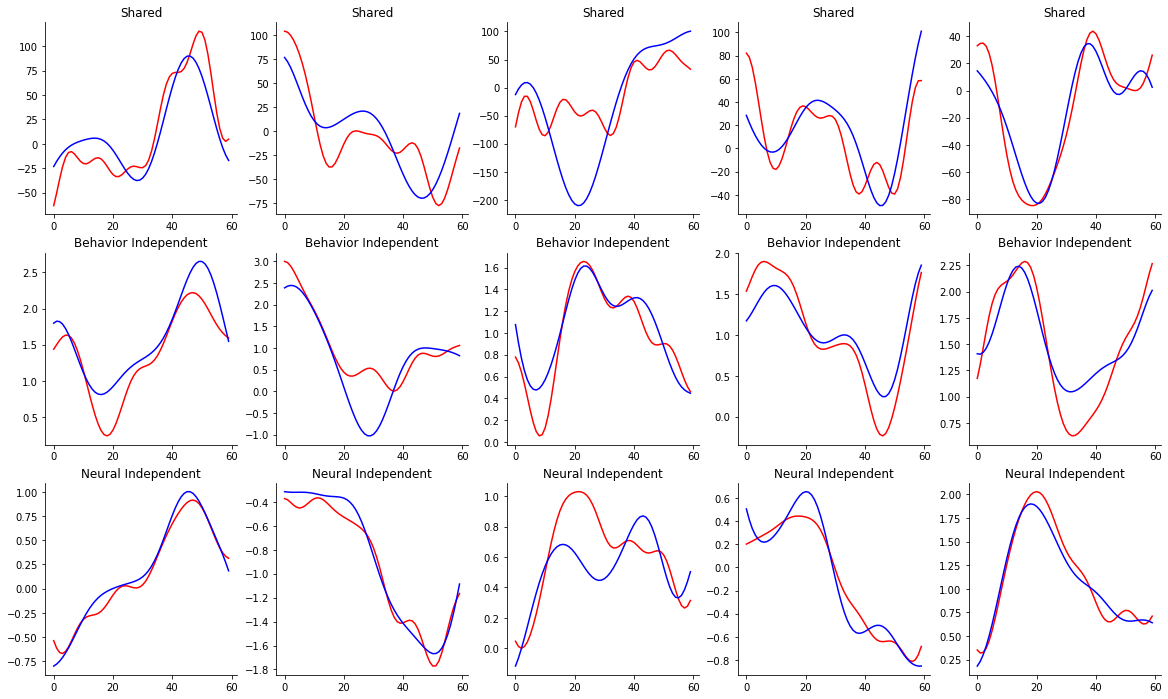

In [9]:
with torch.no_grad():
    regressions(net = net, n_encode= n_encode, n_decode = n_decode,
                data_load=loader_test, BATCH=BATCH, cols = 5, trial_number=7, 
                batch_number=0, Fourier=FOURIER)

## Visualizing the neural rates

<Figure size 1500x300 with 0 Axes>

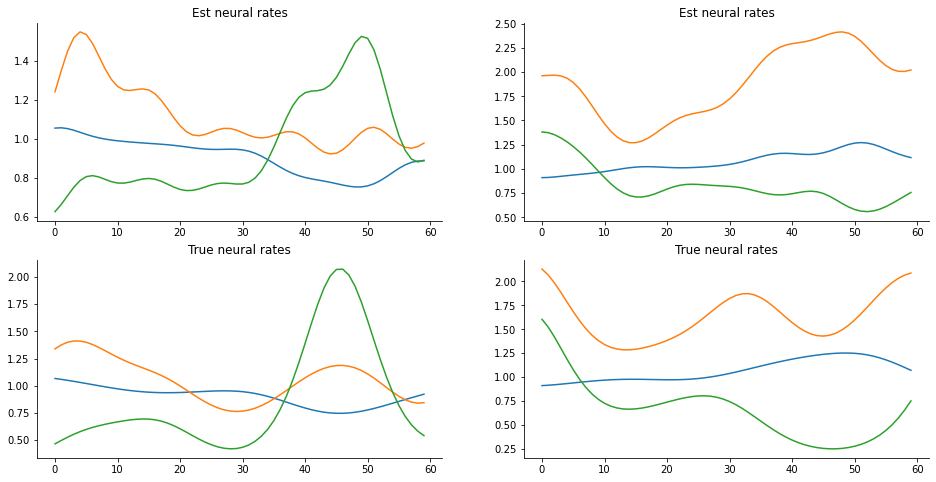

In [10]:
with torch.no_grad():
    plot_figures(image = False, net = net, n_encode= n_encode, n_decode = n_decode,
                data_load=loader_test, BATCH=BATCH, Fourier=FOURIER, 
                cols = 2, trial_number=7, batch_number=0)


## Visualizing the 3s

<Figure size 1500x300 with 0 Axes>

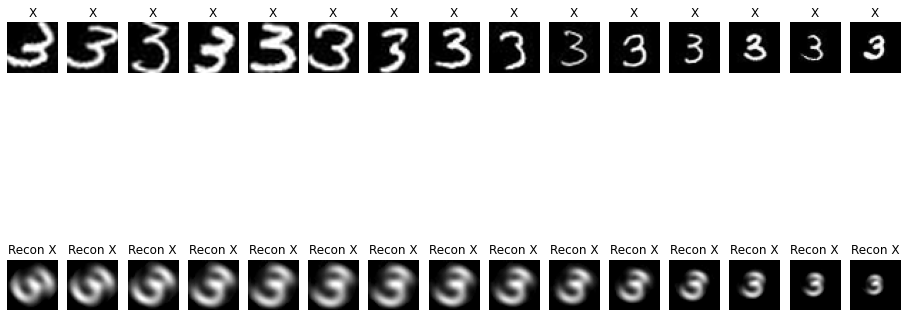

In [11]:
with torch.no_grad():
    plot_figures(image = True, net = net, n_encode= n_encode, n_decode = n_decode,
                data_load= loader_test, BATCH=BATCH, Fourier=FOURIER, 
                cols = 15, trial_number=7, batch_number=0)

# Saving the MMGPVAE model

In [12]:
save_multimodal(net, n_encode, n_decode, test_data_unbatched, FOURIER = True,
                    name = MMGPVAE, zero_image = 1,
                    zero_neuron = 1, mmgpvae= True, gpfa= False, gpvae=False)

torch.Size([60, 60])
torch.Size([60, 60])
